In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# torch lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

# torch
import torch
from torch.utils.data import random_split

#vision
from torchvision.transforms import v2 as T

# utils
from copy import copy
import json
import numpy as np

# custom utils
from datasets.dataset import *
from helper_utils.display import display_sample, plot_losses, display_mask
from models.smp_model import CatSegModel

c:\Users\Jonathan\Documents\GitHub\CataractIrisSegmentation_SMP\models\smp_model.py:115: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if "stage" is not 'test':


In [3]:
# paths 
data_root = "H:\Cataract Dataset\FSR Dataset\Yolo_Segmentation_640x640"
inference_data_root = 'H:\Cataract Dataset\FSR Dataset\Ori_youtube_20'
config_path = 'configs/Unet_resnet34_train.json'
os.environ['TORCH_HOME'] = 'models/torch'


### Data prep
Define transforms for the data:

In [4]:
# Example transformations
# @TODO: what is the corect image size
data_transforms = {}
data_transforms['train'] = T.Compose([
    T.RandomResizedCrop(size=640, scale=(0.5, 1)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToImage(),
    #T.ToDtype(torch.float32, scale=True)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_transforms['valid'] = T.Compose([
    T.Resize(670),
    T.CenterCrop(640),
    T.ToImage(),
    #T.ToDtype(torch.float32, scale=True)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_transforms['test'] = data_transforms['valid']

Build dataset:

In [5]:
# get files
full_dataset = SegmentationDataset(data_root)

# specify sizes
train_ratio = 0.7 # from total count
valid_ratio = 0.15 # from total count

# build datasets
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
valid_size = int(valid_ratio * total_size)
test_size = total_size - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])
train_dataset.dataset = copy(full_dataset) # disgusting solution for pytorch

# apply transforms
train_dataset.dataset.transform = data_transforms['train']
valid_dataset.dataset.transform = data_transforms['valid']
test_dataset.dataset.transform = data_transforms['test']

Plot a few images for example:

In [6]:
'''
for _ in range(3):
    index = np.random.randint(0, len(test_dataset) - 1)
    display_sample(train_dataset, index)
    '''

'\nfor _ in range(3):\n    index = np.random.randint(0, len(test_dataset) - 1)\n    display_sample(train_dataset, index)\n    '

In [7]:
# Generate files split
train_dl, valid_dl, test_dl =  build_dataloaders(train_dataset, valid_dataset, test_dataset)

### Build model
Config load:

In [8]:
with open(config_path) as f:
    config = json.load(f)
print(json.dumps(config, indent=1))

{
 "NAME": "Unet_resnet34_pretrained_DiceLoss",
 "MODE": "train",
 "NUM_EPOCHS": 10,
 "CLASSES": [
  "pupil"
 ],
 "IN_CH": 3,
 "ARCH": "Unet",
 "ENCODER": "resnet34",
 "ENCODER_WEIGHTS": "imagenet",
 "LOSS": "DiceLoss",
 "LR": 0.0001,
 "AUX_PARAMS": {
  "dropout": 0.5
 }
}


Build custom model using SMP library and the configuration file:

In [9]:
# setup
torch.set_float32_matmul_precision('high')
# build model
if config['MODE'] == 'train':
    model = CatSegModel(config)
    
elif config['MODE'] == 'load':
    load_path = config['MODEL_PATH']+f"\{config['NAME']}_best-checkpoint.ckpt"
    model = CatSegModel.load_from_checkpoint(
        checkpoint_path=load_path,
        hparams_file=config['MODEL_PATH']+"\hparams.yaml"
    )

#### Train and validation loop:

Missing logger folder: logs\Unet_resnet34_pretrained_DiceLoss
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 24.4 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Jonathan\.conda\envs\custom_CatSemSeg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


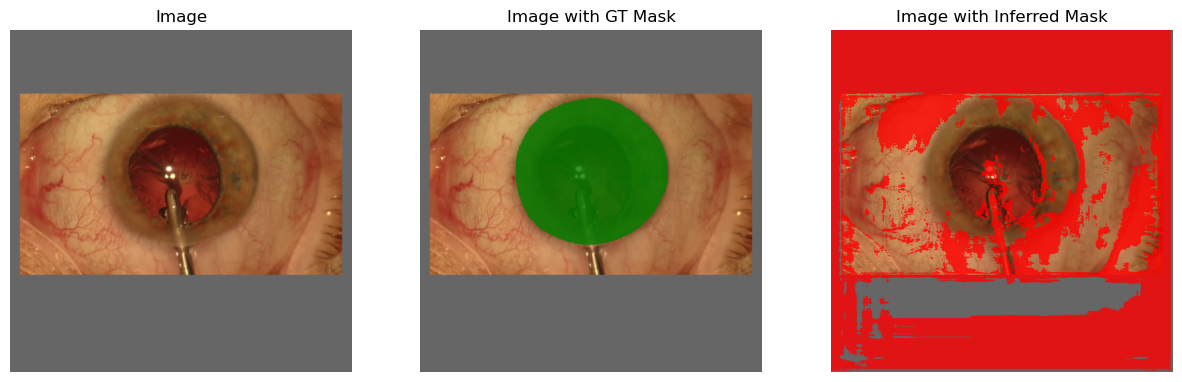

c:\Users\Jonathan\.conda\envs\custom_CatSemSeg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [10]:
# Set up the logger 
log_root = 'logs'
csv_logger = CSVLogger(log_root, config['NAME'])

# Create a ModelCheckpoint callback to save only the best model
callback_path = os.path.join(csv_logger.save_dir, csv_logger.name, f'version_{csv_logger.version}')
checkpoint_callback = ModelCheckpoint(
    monitor='valid_dataset_loss',  # the metric to monitor
    dirpath=callback_path,
    filename=csv_logger.name+'_best-checkpoint',  # name of the best model file
    save_top_k=1,  # save only the best model
    mode='min'  # save the model with minimum validation loss
)

# create a trainer
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=config.get('NUM_EPOCHS', 10),
    enable_progress_bar=True,
    callbacks=[checkpoint_callback],  
    logger = csv_logger,
)

if config['MODE'] == 'train':
    trainer.fit(
        model, 
        train_dataloaders=train_dl, 
        val_dataloaders=valid_dl,
    )

#### Training Convergance

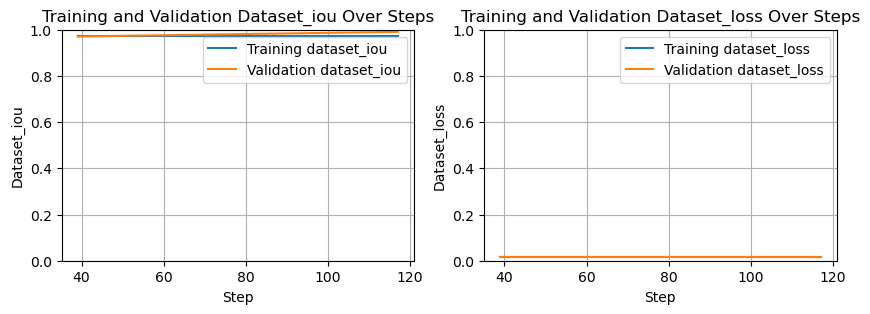

In [ ]:
if config['MODE'] == 'train':
    pth = os.path.join(csv_logger.log_dir, 'metrics.csv')
    #pth = "logs\\Unet_resnet34_pretrained_DiceLoss\\version_0\\metrics.csv"
    plot_losses(pth, ['dataset_iou', 'dataset_loss'])

### Test and Evaluate

In [ ]:
# configure the test logger
test_csv_logger = CSVLogger(config['MODEL_PATH'], 'test')
trainer.logger = test_csv_logger

with torch.no_grad():
    model.eval()
    logger = test_csv_logger,
    tt=trainer.test(model= model, dataloaders = test_dl)

Missing logger folder: logs\Unet_resnet34_pretrained_DiceLoss\version_0\test
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Jonathan\.conda\envs\custom_CatSemSeg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test_dataset_iou         0.973405122756958
    test_dataset_loss      0.018459828570485115
   test_per_image_iou       0.9729897379875183
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Test preformance:

In [ ]:
pth = os.path.join(test_csv_logger.log_dir, 'metrics.csv')
pth = "logs\\Unet_resnet34_pretrained_DiceLoss\\version_0\\test\\metrics.csv"
plot_losses(pth, ['dataset_iou', 'dataset_loss'])

### Inference on test dataset

In [ ]:
# build dataset
infer_dataset = SegmentationInferenceDataset(inference_data_root, transform=data_transforms['test'])
infer_dl = DataLoader(infer_dataset, batch_size=1, shuffle=False, pin_memory=True)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer = pl.Trainer()

# infer
model.eval()
trainer.logger = None
pred = trainer.predict(model, infer_dl.dataset)
trainer.predict

In [ ]:
pred

[tensor([[[[-2.1767, -3.1739, -3.1045,  ..., -4.3218, -3.6184, -1.9827],
           [-3.1732, -4.4568, -3.7627,  ..., -5.7159, -5.6890, -2.9582],
           [-2.9643, -3.9158, -3.3474,  ..., -4.8447, -5.5481, -3.3382],
           ...,
           [-3.1089, -4.9340, -5.8352,  ..., -2.9775, -4.0012, -2.8693],
           [-2.4859, -3.7094, -4.2260,  ..., -1.8979, -2.6216, -1.3359],
           [-1.5240, -2.2377, -2.4835,  ..., -1.3143, -1.5996, -1.1249]]]]),
 tensor([[[[-2.1764, -3.1734, -3.1038,  ..., -4.3219, -3.6184, -1.9823],
           [-3.1729, -4.4559, -3.7618,  ..., -5.7152, -5.6879, -2.9575],
           [-2.9641, -3.9156, -3.3468,  ..., -4.8439, -5.5477, -3.3380],
           ...,
           [-3.1088, -4.9345, -5.8360,  ..., -2.9769, -4.0008, -2.8691],
           [-2.4864, -3.7106, -4.2278,  ..., -1.8977, -2.6215, -1.3361],
           [-1.5240, -2.2380, -2.4840,  ..., -1.3143, -1.5999, -1.1251]]]]),
 tensor([[[[-2.1766, -3.1777, -3.1073,  ..., -4.3244, -3.6201, -1.9842],
           